In [10]:
#Importation des données
import numpy as np 
import pandas as pd 
from collections import Counter



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [11]:
import seaborn as sns 
import matplotlib.pyplot as plt
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline

from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import average_precision_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, precision_recall_curve

import warnings
warnings.simplefilter('ignore')

# OBSERVATION DES DONNÉES

In [14]:
data_train = pd.read_csv("train.csv")
data_train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


## CORRÉLATION

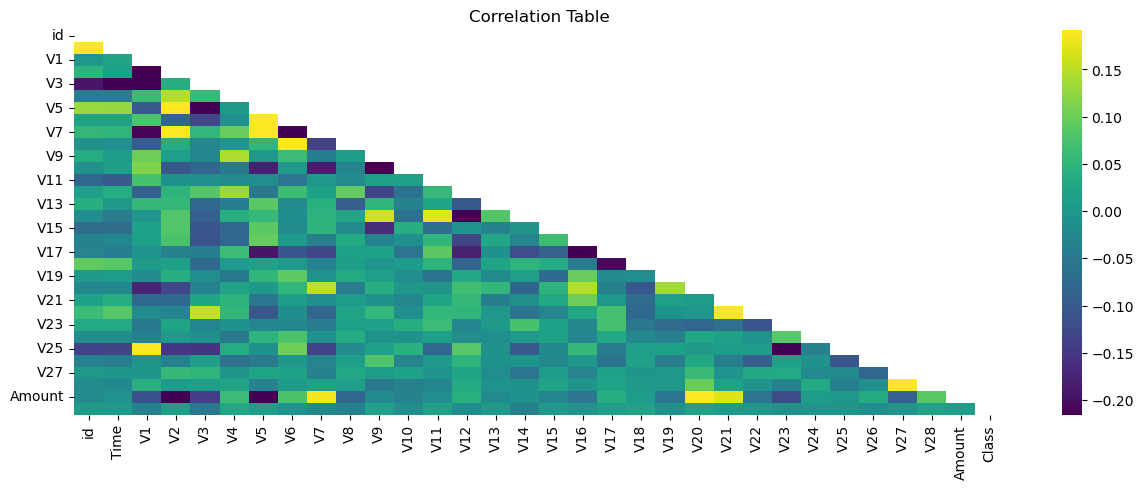

In [15]:
data_corr = data_train.corr()
plt.figure(figsize = (15,5))
mask = np.triu(np.ones_like(data_corr, dtype=bool))
sns.heatmap(data_corr, mask = mask, robust = True, cmap="viridis")
plt.title('Table de corrélations')
plt.show()

## Analyse des données

On remarque que certains variable tels que V3 et V1 sont moins corréler que d autres, mais dans l'ensemble, il n'y a pas une grande corrélation entre les variables

In [16]:
columns  = list(data_train.columns)
data_description = pd.DataFrame()
for i in columns:
    desc = pd.DataFrame(data_train[i].describe())
    data_description.index = desc.index
    data_description[i] = desc[i]
    
data_description.transpose()

,count,mean,std,min,25%,50%,75%,max
id,219129.0,109564.000000,63257.237906,0.000000,54782.000000,109564.000000,164346.000000,219128.000000
Time,219129.0,62377.415376,25620.348569,0.000000,47933.000000,63189.000000,77519.000000,120580.000000
V1,219129.0,0.096008,1.395425,-29.807725,-0.846135,0.385913,1.190661,2.430494
V2,219129.0,0.048345,1.159805,-44.247914,-0.573728,0.046937,0.814145,16.068473
V3,219129.0,0.592102,1.132884,-19.722872,-0.027154,0.735895,1.306110,6.145578
V4,219129.0,0.069273,1.253125,-5.263650,-0.769256,0.064856,0.919353,12.547997
V5,219129.0,-0.161555,1.069530,-37.591259,-0.847346,-0.229929,0.356856,34.581260
V6,219129.0,0.133688,1.202411,-25.659750,-0.631835,-0.087778,0.482388,16.233967
V7,219129.0,-0.128224,0.817207,-31.179799,-0.646730,-0.098970,0.385567,39.824099
V8,219129.0,0.149534,0.716212,-28.903442,-0.095948,0.111219,0.390976,18.270586


1. Les valeurs sont normalisées à l'aide de l'ACP (Analyse en Composantes Principales) et elles se situent dans une plage de valeurs de négatif à positif.
2. Il n'y a pas de valeurs négatives dans les champs montant (Amount), temps (Time) et classe (Class).
3. 75 % des transactions étaient inférieures à 68,9 $.



In [17]:
class_1 = data_train[data_train['Class']==1]
class_1

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
1681,1681,764.0,0.845797,-1.063059,0.120133,-0.312570,-0.056194,1.944391,-0.661839,0.582721,...,-0.430906,-0.919078,0.123612,-1.420935,-0.072559,0.293439,0.061270,0.006448,136.58,1
2039,2039,923.0,-1.808089,1.794735,-2.574549,-1.944174,-4.093440,-1.360198,-8.837694,-3.865127,...,-2.662635,1.173416,-0.136751,0.739760,-0.692745,0.818293,0.745100,0.847648,2.00,1
2090,2090,1028.0,-0.368027,1.492913,0.653399,0.164478,-1.043918,0.766250,-2.717382,-6.944203,...,-0.058687,1.185031,0.290564,0.528459,0.764303,-0.017768,0.110884,0.307835,0.12,1
3072,3072,1328.0,1.990241,-0.185837,-1.039174,0.086245,0.107037,-0.409425,0.016713,-0.126446,...,-0.142725,-0.285513,0.263769,0.779628,-0.261358,0.255895,-0.074999,-0.059828,23.31,1
3780,3780,1438.0,-0.738582,0.654464,0.652465,-0.139933,1.183689,-0.037131,0.638169,0.136502,...,0.167918,0.563421,0.012614,-0.311213,0.105798,-0.252849,0.049231,0.108966,4.99,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218320,218320,120164.0,2.169813,-0.045807,-2.079652,0.207907,0.722241,-0.966274,0.564011,-0.381757,...,0.054715,0.235221,-0.041338,0.084528,0.363729,0.749486,-0.136626,-0.082399,6.99,1
218396,218396,120185.0,-11.419870,-39.517039,-15.773813,3.756988,-1.482355,-3.490795,-3.917593,0.865307,...,1.818999,0.936693,-0.072615,-0.664149,-0.494026,0.867453,-2.758080,0.185558,498.25,1
218404,218404,120188.0,1.708900,-1.003900,-1.531147,-0.173086,-0.430068,-0.367895,-0.073634,-0.231775,...,-0.099366,0.061036,-0.078629,0.009812,0.057939,-0.466157,0.049888,0.001680,229.99,1
218937,218937,120550.0,-1.330035,1.912497,0.058653,4.098485,0.555525,1.281339,-0.332319,1.016770,...,-0.380175,-1.235965,0.287937,-0.391235,-0.871630,0.080706,0.179565,-0.092588,20.00,1


In [18]:
class_1['Time'].describe()

count       469.000000
mean      66188.392324
std       27776.806184
min         764.000000
25%       50907.000000
50%       69297.000000
75%       82563.000000
max      120573.000000
Name: Time, dtype: float64

In [19]:
class_0= data_train[data_train['Class']==0]
class_0

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219124,219124,120580.0,1.891079,-1.272908,-3.783908,-1.388939,2.012789,2.666080,0.151740,0.401934,...,-0.181369,-0.456538,-0.069571,0.756765,0.244479,-0.147566,-0.054725,-0.044588,198.65,0
219125,219125,120580.0,0.139724,0.948649,-2.913655,-2.184829,1.883716,-1.056824,1.725624,0.018089,...,0.491469,1.478823,-0.085398,-0.091409,-1.053488,0.467570,0.358918,0.294735,24.00,0
219126,219126,120580.0,2.058343,-0.038993,-1.928553,0.330117,0.270127,-0.735664,-0.173878,0.144823,...,-0.306640,-0.965783,0.307799,-0.021434,-0.343989,0.181065,-0.098387,-0.044064,1.79,0
219127,219127,120580.0,2.079227,-2.162389,-1.785833,-2.804889,0.552845,4.038013,-2.155900,1.023785,...,0.109909,0.590401,0.286621,0.675660,-0.510736,-0.090044,0.056749,-0.017126,88.00,0


In [20]:
class_0['Time'].describe()

count    218660.000000
mean      62369.241279
std       25614.987596
min           0.000000
25%       47933.000000
50%       63181.000000
75%       77515.000000
max      120580.000000
Name: Time, dtype: float64

In [21]:
class_1['Amount'].describe()

count     469.000000
mean      108.391002
std       376.603036
min         0.000000
25%         1.000000
50%         8.760000
75%        39.950000
max      4471.960000
Name: Amount, dtype: float64

<Axes: >

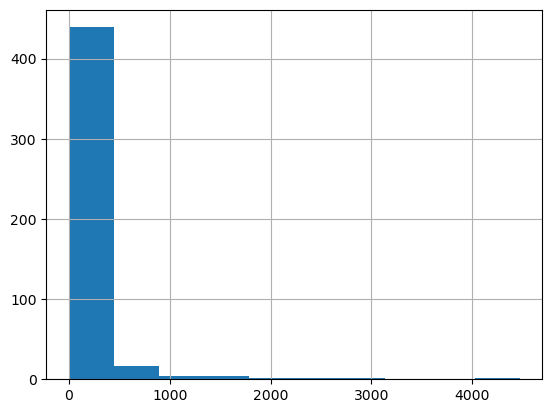

In [22]:
class_1['Amount'].hist()

In [23]:
class_0['Amount'].describe()

count    218660.000000
mean         66.269651
std         149.935158
min           0.000000
25%           5.990000
50%          21.900000
75%          68.970000
max        7475.000000
Name: Amount, dtype: float64

Analyse des classes 0 et 1
1. Temps - Le temps écoulé pour les deux cas est assez similaire l'un à l'autre. Par conséquent, je ne détecte aucune corrélation entre eux.

2. Montant - En considérant uniquement les transactions frauduleuses, seulement 25 % se situent entre 70 et 4 000 $. Cela indique que le montant volé est très faible.

<Axes: ylabel='Frequency'>

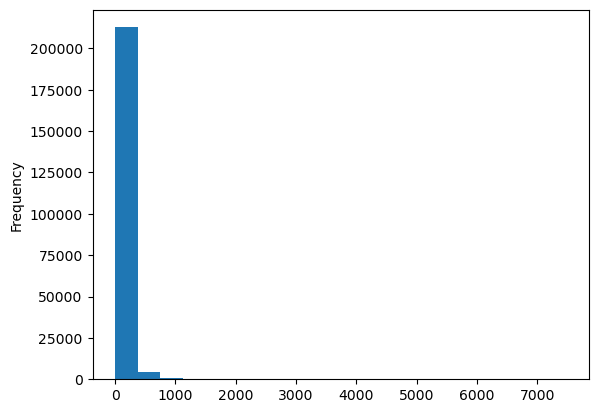

In [24]:
data_train['Amount'].plot(kind='hist',bins = 20)

<Axes: xlabel='Amount'>

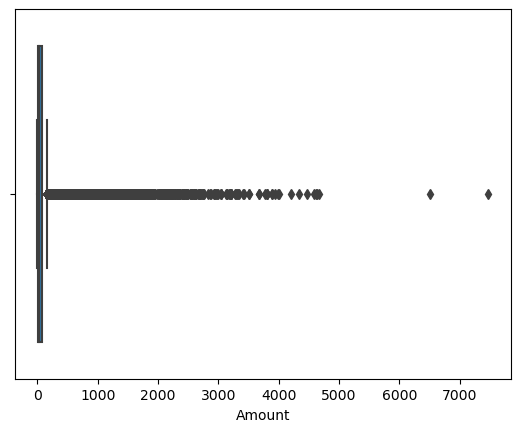

In [25]:
sns.boxplot(x=data_train['Amount'])

<Axes: xlabel='V20', ylabel='Amount'>

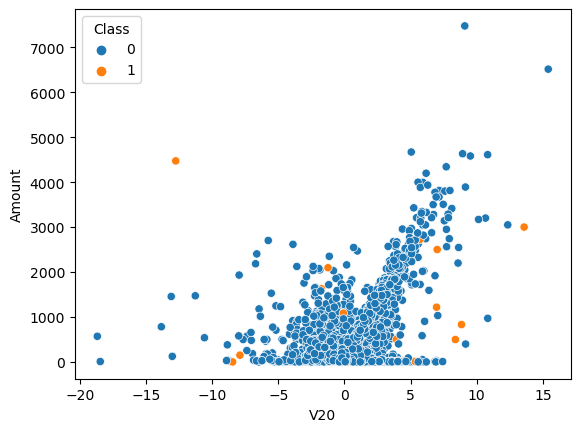

In [26]:
sns.scatterplot(x = 'V20',y='Amount', data = data_train,hue ='Class')


<Axes: xlabel='V21', ylabel='Amount'>

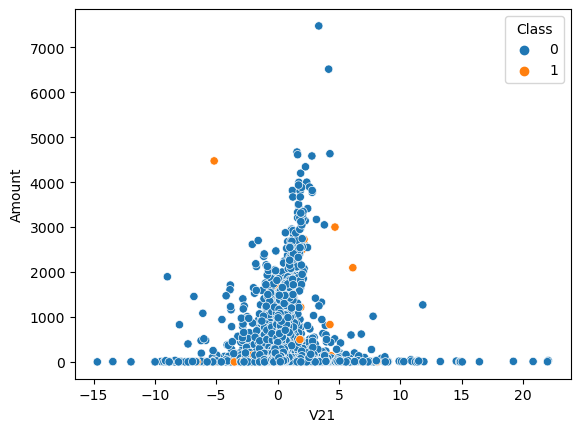

In [27]:
sns.scatterplot(x = 'V21',y='Amount', data = data_train,hue ='Class')

Transactions légitimes vs frauduleuses

In [28]:
data_train['Class'].value_counts()/data_train['Class'].value_counts().sum() * 100

0    99.785971
1     0.214029
Name: Class, dtype: float64

In [29]:
data_train['Class'].value_counts()

0    218660
1       469
Name: Class, dtype: int64

Étant donné que l'ensemble de données présente un fort déséquilibre, nous pouvons créer un échantillon représentatif de l'ensemble de données et commencer à partir de là.

In [30]:
data_sample = data_train.sample(frac = 1)

data_fraud = data_sample.loc[data_sample['Class']==1]
data_true = data_sample.loc[data_sample['Class']==0][:470]

In [31]:
data_resampled = pd.concat([data_fraud,data_true])
data_resampled = data_resampled.sample(frac =1,random_state = 51)
data_resampled.reset_index(inplace = True, drop = True)
data_resampled.drop(columns=['id'],inplace = True)
data_resampled

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,17498.0,-1.271571,1.085978,1.087866,0.282498,0.696535,-0.466739,0.603568,-0.213012,1.414917,...,-0.151277,-0.126731,-0.016401,-0.026291,0.272526,-0.484849,-0.351180,0.263745,3.90,1
1,53968.0,0.643312,-0.867705,0.580825,1.235749,-0.735674,0.653657,-0.337010,0.316360,0.233855,...,0.332738,0.428839,-0.317428,-0.330947,0.292529,-0.290746,0.002451,0.061067,259.00,0
2,54859.0,-0.783869,0.507054,1.826583,0.816278,-0.791465,0.272789,-0.396901,0.691402,0.591875,...,0.154424,0.464924,0.060041,0.071339,-0.328723,-0.567782,-0.091447,-0.058491,33.22,0
3,84968.0,-0.716482,1.366864,1.317961,0.090698,0.008845,-0.165564,0.451779,-0.083358,0.167595,...,-0.106908,-0.094339,-0.003917,0.067564,-0.704824,0.122649,0.352379,-0.007715,1.89,0
4,71834.0,-0.856678,1.362925,0.462033,-0.090916,0.771681,-0.330802,0.822135,0.147961,-1.088913,...,0.083527,0.024969,-0.432339,-0.711894,0.735489,-0.321365,-0.182524,-0.073315,0.76,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,38730.0,0.632278,-0.895673,0.292908,0.227768,-0.825225,-0.203518,0.032827,0.018330,0.169357,...,0.185998,-0.013741,-0.233248,0.322766,0.162468,0.955696,-0.104565,0.040987,274.00,0
935,81952.0,-1.135989,0.940026,1.097153,1.183881,-0.284070,-1.071519,0.287877,0.367779,-0.846929,...,0.240843,0.634007,-0.132437,0.622810,0.002906,-0.210774,0.043690,0.064276,10.00,0
936,39769.0,0.929379,-1.085846,1.226723,0.468051,-1.596717,0.208928,-0.966572,0.066887,-0.031031,...,0.084028,0.573415,-0.103651,0.105675,0.302701,-0.259550,0.091249,0.070612,168.00,0
937,75842.0,1.375029,-0.547260,-0.728246,-0.653348,-0.324452,-0.933034,0.060849,-0.328978,-1.208959,...,-0.224496,-0.236426,-0.213066,-0.072529,0.605556,1.107534,-0.125537,-0.010807,68.45,0


### mise en échelle de Time et amount

In [32]:
from sklearn.preprocessing import  RobustScaler
from sklearn.model_selection import train_test_split

rc = RobustScaler()
data_resampled['Time'] = rc.fit_transform(data_resampled['Time'].values.reshape(-1,1))
data_resampled['Amount'] = rc.fit_transform(data_resampled['Amount'].values.reshape(-1,1))


In [33]:
data_resampled

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.525513,-1.271571,1.085978,1.087866,0.282498,0.696535,-0.466739,0.603568,-0.213012,1.414917,...,-0.151277,-0.126731,-0.016401,-0.026291,0.272526,-0.484849,-0.351180,0.263745,-0.205114,1
1,-0.371107,0.643312,-0.867705,0.580825,1.235749,-0.735674,0.653657,-0.337010,0.316360,0.233855,...,0.332738,0.428839,-0.317428,-0.330947,0.292529,-0.290746,0.002451,0.061067,4.470901,0
2,-0.342903,-0.783869,0.507054,1.826583,0.816278,-0.791465,0.272789,-0.396901,0.691402,0.591875,...,0.154424,0.464924,0.060041,0.071339,-0.328723,-0.567782,-0.091447,-0.058491,0.332325,0
3,0.610154,-0.716482,1.366864,1.317961,0.090698,0.008845,-0.165564,0.451779,-0.083358,0.167595,...,-0.106908,-0.094339,-0.003917,0.067564,-0.704824,0.122649,0.352379,-0.007715,-0.241958,0
4,0.194416,-0.856678,1.362925,0.462033,-0.090916,0.771681,-0.330802,0.822135,0.147961,-1.088913,...,0.083527,0.024969,-0.432339,-0.711894,0.735489,-0.321365,-0.182524,-0.073315,-0.262671,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,-0.853444,0.632278,-0.895673,0.292908,0.227768,-0.825225,-0.203518,0.032827,0.018330,0.169357,...,0.185998,-0.013741,-0.233248,0.322766,0.162468,0.955696,-0.104565,0.040987,4.745853,0
935,0.514687,-1.135989,0.940026,1.097153,1.183881,-0.284070,-1.071519,0.287877,0.367779,-0.846929,...,0.240843,0.634007,-0.132437,0.622810,0.002906,-0.210774,0.043690,0.064276,-0.093300,0
936,-0.820556,0.929379,-1.085846,1.226723,0.468051,-1.596717,0.208928,-0.966572,0.066887,-0.031031,...,0.084028,0.573415,-0.103651,0.105675,0.302701,-0.259550,0.091249,0.070612,2.802859,0
937,0.321284,1.375029,-0.547260,-0.728246,-0.653348,-0.324452,-0.933034,0.060849,-0.328978,-1.208959,...,-0.224496,-0.236426,-0.213066,-0.072529,0.605556,1.107534,-0.125537,-0.010807,0.978095,0


In [34]:
data_resampled.Class.value_counts()

0    470
1    469
Name: Class, dtype: int64

## COMPARAISON DES MODÈLES

In [37]:
X = data_resampled.drop('Class', axis=1)
y = data_resampled['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Le classifieur: ", classifier.__class__.__name__, "", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 70.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 69.0 % accuracy score
Classifiers:  SVC Has a training score of 71.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 62.0 % accuracy score


En moyenne SVC et LogisticRegression sont les algorithmes les plus efficaces

In [38]:
test = pd.read_csv("test.csv")
data_test =test.copy()
data_test.drop(columns=['id'],inplace = True)
data_test['Time'] = rc.fit_transform(data_test['Time'].values.reshape(-1,1))
data_test['Amount'] = rc.fit_transform(data_test['Amount'].values.reshape(-1,1))
data_test

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.020092,2.115519,-0.691809,-1.305514,-0.685655,-0.641265,-0.764784,-0.924262,-0.023030,-0.230126,...,0.067367,0.241708,0.682524,0.037769,-0.546859,-0.123055,-0.084889,0.004720,-0.021944,0.135977
1,-1.020092,1.743525,-1.681429,-0.547387,-1.061113,-0.695825,2.458824,-1.632859,1.073529,1.068183,...,0.441788,0.543278,1.294571,0.309541,3.703925,-0.242579,0.068708,0.002629,0.064690,2.361440
2,-1.020092,2.205568,-1.571445,-0.238965,-1.662517,-1.652324,-0.054701,-1.682064,0.105613,-1.177858,...,-0.366906,-0.131527,0.086623,0.291375,0.739087,-0.543006,-0.297813,0.043699,-0.037855,-0.096484
3,-1.020092,1.989728,-0.972909,-1.938259,-1.440129,-0.166855,-0.794048,0.252889,-0.399789,2.079398,...,-0.049136,-0.080115,-0.010732,-0.038550,0.656830,0.343470,-0.627529,-0.024338,-0.036143,1.652891
4,-1.020092,-1.943548,-1.668761,0.363601,-0.977610,2.684779,-2.037681,0.039709,-0.048895,-0.281749,...,0.391627,0.083389,-0.306918,0.247822,-0.391799,-0.790716,-0.025706,0.330758,0.335537,-0.330112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146082,1.207064,-0.661834,-0.622980,0.735580,-0.554067,0.869889,-0.389502,0.161226,0.069945,0.698829,...,0.262408,-0.046068,-0.425692,0.253833,-1.076331,-0.999877,0.161938,0.149243,0.279708,1.216797
146083,1.207064,-0.098889,0.761900,0.340012,-0.589546,0.717091,-0.262765,0.726272,-0.070608,0.095958,...,0.064640,0.441215,1.284819,-0.141790,0.646930,-0.419964,-0.561426,0.326700,0.255166,0.053324
146084,1.207064,-1.487918,1.769142,0.551671,0.361566,0.056347,0.084844,0.567545,-0.059899,0.331706,...,0.792736,0.163500,1.287079,-0.186955,-0.349847,-0.161724,-0.213933,0.392745,0.070938,0.136644
146085,1.207107,-1.889979,-0.154869,0.068496,-1.906964,-1.743181,0.717490,0.981608,-0.209713,-0.556087,...,-0.513829,0.121457,0.764642,-0.217844,0.104599,-0.008906,-0.204957,-0.752326,-0.155728,4.869355


In [40]:
log_reg = LogisticRegression(solver='liblinear', random_state=0)
log_reg.fit(X_train,y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [30]:
y_pred_test = log_reg.predict(X_test)
y_pred_test

array([0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1])

In [31]:
from sklearn.metrics import accuracy_score

print('Score de précision du modèle: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.6809


In [32]:
print('Score du set de training: {:.4f}'.format(log_reg.score(X_train, y_train)))

print('Score du set de test: {:.4f}'.format(log_reg.score(X_test, y_test)))

Training set score: 0.7750
Test set score: 0.6809


PRÉDICTION FINAL

In [33]:
y_pred_test = log_reg.predict(test_df)
y_pred_test

array([0, 0, 0, ..., 1, 0, 0])

In [34]:
log_reg.predict_proba(test_df)

array([[0.74983358, 0.25016642],
       [0.82043445, 0.17956555],
       [0.94709341, 0.05290659],
       ...,
       [0.35185808, 0.64814192],
       [0.95736332, 0.04263668],
       [0.90238023, 0.09761977]])

## Rééchantillonnage de l'ensemble de données avec une autre méthode

In [58]:
data_train['Time'] = rc.fit_transform(data_train['Time'].values.reshape(-1,1))
data_train['Amount'] = rc.fit_transform(data_train['Amount'].values.reshape(-1,1))
data_train

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-2.135774,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,-0.316492,0
1,1,-2.135774,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,0.986654,0
2,2,-2.135774,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,-0.305211,0
3,3,-2.135774,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,-0.332062,0
4,4,-2.135774,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,-0.332062,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219124,219124,1.939803,1.891079,-1.272908,-3.783908,-1.388939,2.012789,2.666080,0.151740,0.401934,...,-0.181369,-0.456538,-0.069571,0.756765,0.244479,-0.147566,-0.054725,-0.044588,2.808230,0
219125,219125,1.939803,0.139724,0.948649,-2.913655,-2.184829,1.883716,-1.056824,1.725624,0.018089,...,0.491469,1.478823,-0.085398,-0.091409,-1.053488,0.467570,0.358918,0.294735,0.033365,0
219126,219126,1.939803,2.058343,-0.038993,-1.928553,0.330117,0.270127,-0.735664,-0.173878,0.144823,...,-0.306640,-0.965783,0.307799,-0.021434,-0.343989,0.181065,-0.098387,-0.044064,-0.319511,0
219127,219127,1.939803,2.079227,-2.162389,-1.785833,-2.804889,0.552845,4.038013,-2.155900,1.023785,...,0.109909,0.590401,0.286621,0.675660,-0.510736,-0.090044,0.056749,-0.017126,1.050207,0


In [59]:
features = data_train.drop(["id","Class"], axis=1)
labels = data_train["Class"]

X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=2023)
print("Dimentions de X_train : {}".format(X_train1.shape))
print("Dimentions de  X_test : {}".format(X_test1.shape))
print("Dimentions de y_train : {}".format(y_train1.shape))
print("Dimentions de  y_test : {}".format(y_test1.shape))

print('Dimensions des Labels y_train :', Counter(y_train1))
print('Dimensions des Labels y_test :', Counter(y_test1))

X_train Shape: (175303, 30)
 X_test Shape: (43826, 30)
y_train Shape: (175303,)
 y_test Shape: (43826,)
Labels y_train shape: Counter({0: 174928, 1: 375})
 Labels y_test shape: Counter({0: 43732, 1: 94})


In [60]:
undersample = OneSidedSelection(n_neighbors=1, n_seeds_S=200, random_state=2023)
undersample_X_train, undersample_y_train = undersample.fit_resample(X_train1, y_train1)

oversample = SMOTE(sampling_strategy=0.7, random_state=2023)
resample_X_train, resample_y_train = oversample.fit_resample(undersample_X_train, undersample_y_train)

final_model = LogisticRegression(random_state=2023, penalty="l2")


final_model.fit(resample_X_train, resample_y_train)

y_pred = final_model.predict(X_test1)
y_score = final_model.predict_proba(X_test1)[:,1]

accuracy = round(accuracy_score(y_test1, y_pred), 4)
recall = round(recall_score(y_test1, y_pred), 4)
precision = round(precision_score(y_test1, y_pred), 4)
f1 = round(f1_score(y_test1, y_pred), 4)
auc_pr = round(average_precision_score(y_test1, y_pred), 4)

In [70]:
y_pred = final_model.predict(test_df)

In [71]:
sub = pd.read_csv('sample_submission.csv')
sub['Class'] = y_pred

In [72]:
print('Score de précision du modèle: {0:0.4f}'. format(accuracy))

Model accuracy score: 0.9229


In [73]:
sub.to_csv('submission.csv',index=False)